In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import json
from pycocotools import mask
TRAIN_DIR = '/content/drive/MyDrive/trainingset'
TEST_DIR = '/content/drive/MyDrive/testset'
TRAIN_LABELS = '/content/drive/MyDrive/train.json'
TEST_LABELS =  '/content/drive/MyDrive/test.json'
IM_WIDTH = 700
IM_HEIGHT = 700

In [ ]:
def groupByImageId(jsonfile):
  data = jsonfile['annotations']
  labs = {}
  for k in data:
    if k['image_id'] in labs:
      labs[k['image_id']].append(k)
    else:
      labs[k['image_id']] = [k]
  return labs


In [ ]:
data =json.load(open(TRAIN_LABELS))
print(os.path.join(TRAIN_DIR,data['images'][0]['file_name']))

/content/drive/MyDrive/trainingset/57_01156.jpg


In [ ]:
class PowerLineDataset(torch.utils.data.Dataset):
  def __init__(self,img_dir,img_labels):
    self.img_dir = img_dir
    self.img_labels = json.load(open(img_labels))
    self.categories = [] #lista delle etichette di classe
    for c in self.img_labels['categories']:
      self.categories.append(c['name']) #forse conviene prendere di più l'id?

  def __getitem__(self,idx):
    img_path = os.path.join(self.img_dir, self.img_labels['images'][idx]['file_name'])
    label = groupByImageId(self.img_labels)[idx]
    image = torchvision.io.read_image(img_path)
    return image,label
  def __len__(self):
    return len(os.listdir(self.img_dir))


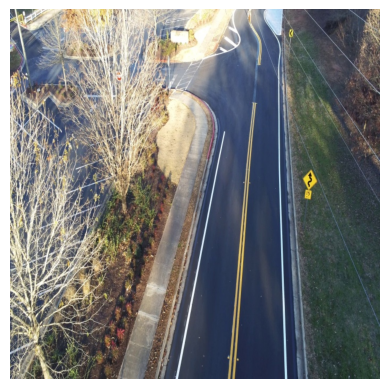

In [ ]:
#provo a stampare un immagine qualsiasi
%matplotlib inline
l = os.listdir(TRAIN_DIR)
path = os.path.join(TRAIN_DIR, l[0])
image = matplotlib.image.imread(path)
plt.figure()
plt.axis('off')
plt.imshow(image)

In [ ]:
#caricamento dei dataset di train e di test
train = PowerLineDataset(TRAIN_DIR, TRAIN_LABELS)
test = PowerLineDataset(TEST_DIR, TEST_LABELS)


preparazione per il training e il testing: dobbiamo modificare le immagini in tensori

In [ ]:
batch_size = 64

# Data loader (prepara i dati per l'addestramento)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
train_loader

In [ ]:
# Itera attraverso il DataLoader e accumula i batch in una lista
data_list = []
for batch in train_loader:
    data_list.append(batch)

# Concatena i batch in un unico tensore
# Sostituisci 0 con la dimensione dell'asse del batch
# (ad esempio, 0 se il batch è il primo asse)
tensor_data = torch.cat(data_list, dim=0)

IndexError: ignored

In [ ]:
def decodeSegmentationField(segmentation):
  return mask.decode(mask.merge(mask.frPyObjects(segmentation,IM_WIDTH,IM_HEIGHT)))



Cerchiamo di replicare ora la Mask R-CNN, che ci serve per implementare la instance segmentation

In [ ]:
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


# Definizione di un modello Mask R-CNN semplificato
class MaskRCNN(nn.Module):
    def __init__(self, num_classes):
        super(MaskRCNN, self).__init__()
        # Caricamento di un modello pre-addestrato di torchvision
        self.maskrcnn = maskrcnn_resnet50_fpn(pretrained=True)
        # Modifica dell'ultimo layer per adattarsi al numero di classi specificato
        in_features = self.maskrcnn.roi_heads.box_predictor.cls_score.in_features
        self.maskrcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        # Modifica dell'ultimo layer per adattarsi al numero di classi e maschere specificati
        in_features_mask = self.maskrcnn.roi_heads.mask_predictor.conv5_mask.in_channels
        self.maskrcnn.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, 256, num_classes)

    def forward(self, images, targets=None):
        if self.training and targets is None:
            raise ValueError("During training, targets should be passed to the model.")

        output = self.maskrcnn(images, targets)
        return output

# Creazione di un'istanza di MaskRCNN per instance segmentation
num_classes = 4  # Numero di classi (background? + oggetti) #se dobbiamo includere anche il background dovremmo avere 5 classi, altrimenti 4
model = MaskRCNN(num_classes)

Provo con una fase di test con l'immagine estratta in precedenza

In [ ]:
#questo metodo è preso dai notebook e va adattato al caso specifico (loss ecc...)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #bisogna definire il model
total_step = len(train)
batch_size = 64

num_epochs = 3

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train) for i in range(num_epochs + 1)]

def train(epoch,model,criterion,optimizer,reshape=True):
    for batch_idx, (images, labels) in enumerate(train):
        # Move tensors to the configured device
        if reshape:
            images = images.reshape(-1, 28*28)
        #images = images.to(device)
        #labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch_idx+1) % 100 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, num_epochs, batch_idx+1, total_step, loss.item()))

        train_losses.append(loss.item())
        train_counter.append(
        (batch_idx*batch_size) + ((epoch-1)*len(train)))

NameError: ignored